# Датасет Narvik Weather (подвыборка из большего датасета, который анализировал в прошлом семестре)

In [1]:
import bamt.preprocessors
import bamt.networks as Nets
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from itertools import product
from pgmpy.estimators import  K2Score

from auxiliary import *

imagespath = 'C:/Users/Acer/PycharmProjects/BAMTclone/BAMT/experiments2/images'

- Уровни признаков после разбиения выносятся в отдельные столбцы в результате one-hot encoding и номер в конце имени признака обозначает уровень этого признака: 0 --- наименьшие значения, 2 --- наибольшие
- Ручное разбиение не рассматривалось, рассмотрены лишь разбиения признаков по уровням по квантилям и равномерное разбиение. У обоих подходов есть свои проблемы: по квантилям можно получить либо меньше уровней разбиения (в том числе и лишь один уровень, так как квантили могут совпасть), а равномерное разбиение может приводить к тому, что данному уровню признака может отвечать малый объём выборки в сравнении с остальными уровнями
- Также рассматривалась зависимость от выбора скора, по которому строится БС. mutual info даёт более простую сеть, чем BIC в рамках подхода с использованием one-hot encoding уровней признаков
- Поскольку нам неинтересно взаимодействие различных уровней одного и того же признака, нужно исключать соответствующие дуги в БС из white-list.

In [2]:
data = pd.read_csv("narvikweather.csv")
data.head()

,Unnamed: 0.1,Unnamed: 0,lat_,lon_,State_,Ta_mean,Ta_min,Ta_max,Tsurf_mean,Tsurf_min,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,93084,93084,68.4317,17.4334,5,12.400000,12.4,12.4,1.810000,1.75,...,15,63,79,0.0,1030,-3,10,182,9,narvik
1,70925,70925,68.4349,17.4320,3,4.711765,4.7,4.9,0.167647,-0.15,...,41,93,89,0.6,1002,-4,6,257,21,narvik
2,47174,47174,68.4117,17.4310,6,5.400000,5.4,5.4,-2.320000,-2.32,...,48,100,94,1.2,1020,-5,1,273,26,narvik
3,163824,163824,68.5296,17.4650,1,12.600000,12.6,12.6,3.230000,3.23,...,28,5,76,0.0,1013,-7,10,105,13,oyjord
4,67379,67379,68.4436,17.4176,4,15.133333,10.6,16.1,2.903333,1.28,...,28,68,78,0.0,1004,-5,10,109,18,narvik


In [3]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'lat_', 'lon_', 'State_', 'Ta_mean',
       'Ta_min', 'Ta_max', 'Tsurf_mean', 'Tsurf_min', 'Tsurf_max',
       'Water_mean', 'Water_min', 'Water_max', 'Speed_mean', 'Speed_min',
       'Speed_max', 'Height_mean', 'Height_min', 'Height_max', 'Tdew_mean',
       'Tdew_min', 'Tdew_max', 'Friction_mean', 'Friction_min', 'Friction_max',
       'Date', 'Time', 'Direction_min', 'Direction_max', 'FullDate',
       'ClosestCity', 'date_time', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'location'],
      dtype='object')

In [4]:
data.visibility.value_counts()

10    690
2      89
4      53
3      36
6      34
7      27
9      26
8      24
5      14
1       4
0       3
Name: visibility, dtype: int64

In [5]:
data.tempC.describe()

count    1000.000000
mean       -4.362000
std         4.542641
min       -15.000000
25%        -7.000000
50%        -4.000000
75%        -1.000000
max         6.000000
Name: tempC, dtype: float64

In [6]:
data.date_time.apply(lambda x: x[0:10]).unique()

array(['2021-01-04', '2021-03-01', '2021-02-12', '2020-12-16',
       '2020-12-28', '2020-12-09', '2020-12-17', '2021-02-17',
       '2021-01-13', '2021-02-01', '2021-02-23', '2020-12-03',
       '2020-12-10', '2020-12-23', '2021-02-22', '2020-12-22',
       '2021-03-03', '2021-01-19', '2020-12-21', '2020-12-15',
       '2021-01-11', '2021-01-28', '2021-01-12', '2020-12-02',
       '2020-12-07', '2020-12-01', '2021-01-06', '2020-12-04',
       '2021-02-09', '2020-11-30', '2021-02-26', '2021-01-21',
       '2021-01-18', '2021-01-29', '2021-01-14', '2021-01-26',
       '2021-02-18', '2021-02-02', '2021-01-07', '2021-01-27',
       '2021-02-08', '2021-01-20', '2021-02-10', '2020-12-18',
       '2021-01-25', '2021-03-02', '2021-02-11', '2020-12-08',
       '2021-01-08', '2020-12-11', '2021-02-24', '2020-12-30',
       '2021-01-22', '2021-01-05', '2021-02-15', '2020-12-29',
       '2020-12-14', '2021-01-15', '2021-02-25', '2021-02-16',
       '2021-02-19', '2021-02-05', '2021-02-03'], dtype

## Разбиение признаков по квантилям

In [3]:
cols = ['cloudcover', 'humidity',
       'pressure', 'tempC', 'visibility', 'windspeedKmph']

In [4]:
np.random.seed(SEED)
random.seed(SEED)

qresult = construct_by_quantiles(data[cols], None)
bn = qresult['bn']

c=bn.plot2(imagespath , "bn13.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


![](images/bn13.png)

In [11]:
c=bn.plot_for_specific_nodes(['humidity0', 'humidity1', 'humidity2'], imagespath , "subbn13.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Равномерное разбиение признаков

In [5]:
np.random.seed(SEED)
random.seed(SEED)

uresult = construct_by_uniform(data[cols], None)
ubn = uresult['bn']

c=ubn.plot2(imagespath , "ubn13.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


![](images/ubn13.png)

In [12]:
c=ubn.plot_for_specific_nodes(['humidity0', 'humidity1', 'humidity2'], imagespath , "sububn13.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Валидные связи
- Высокое давление --- высокая температура атмосферы
- низкая облачность --- низкая влажность и высокая температура *The researchers concluded that cloud cover is directly proportional to humidity and inversely proportional to temperature.* (https://www.globe.gov/documents/10157/5c1db298-1dd3-4fb1-8e40-daa3464dbcaa#:~:text=The%20researchers%20concluded%20that%20cloud,cloud%20cover%20increases%20temperature%20decreases.)

## KMeansDiscretizer с тремя bin'ами

In [7]:
np.random.seed(SEED)
random.seed(SEED)

kresult = construct_by_kmeans(data[cols], [])
kbn = kresult['bn']

c=kbn.plot2(imagespath , "kbn13.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


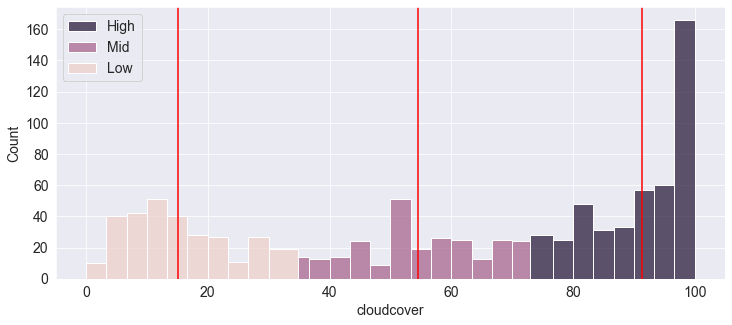

In [28]:
print_histogram('cloudcover')

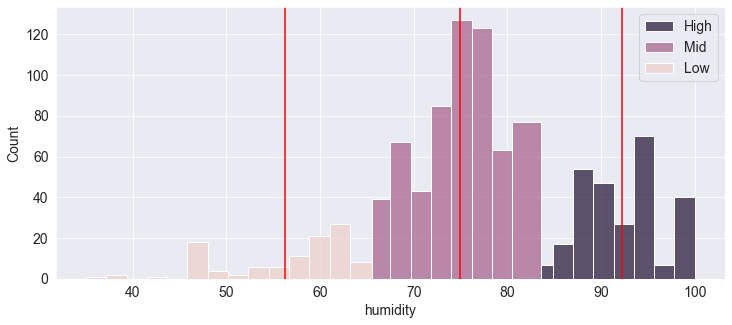

In [29]:
print_histogram('humidity')

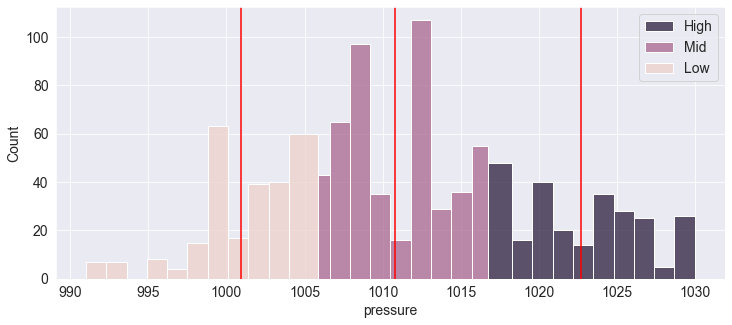

In [30]:
print_histogram('pressure')

![](images/kbn13.png)

In [13]:
c=kbn.plot_for_specific_nodes(['humidity0', 'humidity1', 'humidity2'], imagespath , "subkbn13.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [8]:
kencoder, data_kdiscretized_enc = kresult['encoder'], kresult['disc_data']

In [9]:
all_edges = list(set(["-".join(e) for e in bn.edges + ubn.edges + kbn.edges])) #white list for the next bn

In [10]:
tradeoffbn = Nets.DiscreteBN()
nodes = list(dict.fromkeys(sum([x.split("-") for x in all_edges], start=[])))
tradeoffbn.add_nodes(dict(types={cat: 'disc' for _, cat in enumerate(nodes)}))

params = {'white_list': [(x[0], x[1]) for x in [y.split("-") for y in all_edges]]}

tradeoffbn.add_edges(data_kdiscretized_enc.astype("int32"), scoring_function=("K2",K2Score), params=params)

c=tradeoffbn.plot2(imagespath, "tbn13.html")

  0%|          | 0/1000000 [00:00<?, ?it/s]

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


![](images/tbn13.png)

In [14]:
c=tradeoffbn.plot_for_specific_nodes(['humidity0', 'humidity1', 'humidity2'], imagespath , "subtbn13.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
